In [1]:
import pandas as pd
import talib as ta

In [2]:
def calc_divergence(df: pd.DataFrame, window=5, pre=3):
    """计算背离"""
    # 顶背离（价格新高但MACD未新高）
    df['price_peak'] = df['close'].rolling(window, center=True).max() == df['close']
    df['macd_peak'] = df['MACD'].rolling(window, center=True).max() == df['MACD']
    # 顶背离（价格新高但MACD未新高）
    df['price_peak'] = df['close'].rolling(window, center=True).max() == df['close']
    df['macd_peak'] = df['MACD'].rolling(window, center=True).max() == df['MACD']
    df['top_divergence'] = (df['price_peak'] & 
                            (df['MACD'] < df['MACD'].shift(pre))).astype(int)
    # 底背离（价格新低但MACD未新低）
    df['price_valley'] = df['close'].rolling(window, center=True).min() == df['close']
    df['macd_valley'] = df['MACD'].rolling(window, center=True).min() == df['MACD']
    df['bottom_divergence'] = (df['price_valley'] & 
                                (df['MACD'] > df['MACD'].shift(pre))).astype(int)

In [3]:
def preprocess_data(df: pd.DataFrame):
    df['MACD'], df['Signal'], df['Hist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MSE'] = (df['close'] - df['close'].mean())/df['close'].std()

    # MACD线瞬时斜率
    df['macd_slope'] = df['MACD'].diff()
    # 移动平均斜率（捕捉趋势强度）
    for window in [3, 5, 10]:
        df[f'macd_slope_ma{window}'] = df['macd_slope'].rolling(window).mean()
    # MACD柱状图变化率
    df['hist_change_rate'] = df['Hist'].pct_change()

    calc_divergence(df, window=5)
    return df.dropna()

In [4]:
df = pd.read_csv('stock.csv', parse_dates=True)
train_df = preprocess_data(df)
feature_df = df[['date','close', 'MSE', 'MACD', 'macd_slope_ma3','macd_slope_ma5', 'hist_change_rate', 'top_divergence','bottom_divergence']]
feature_df.tail()

,date,close,MSE,MACD,macd_slope_ma3,macd_slope_ma5,hist_change_rate,top_divergence,bottom_divergence
129423,2025-03-14 19:30:00,1902.16,0.310127,6.393393,0.091426,-0.038197,0.174751,0,0
129424,2025-03-14 20:00:00,1903.02,0.310825,6.447754,0.151343,0.041746,0.031789,0,0
129425,2025-03-14 20:30:00,1902.37,0.310297,6.365014,0.015478,0.049180,-0.541928,0,0
129426,2025-03-14 21:00:00,1898.69,0.307312,5.934092,-0.153101,-0.011927,-4.087606,0,0
129427,2025-03-14 21:30:00,1908.77,0.315490,6.332952,-0.038267,0.002875,-1.365421,0,0


In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def plot_stock(df, n=100):
    plt.rcParams['font.sans-serif'] = ['SimHei','DejaVu Sans','Bitstream Vera Sans','Arial Serif','freeserif','sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    tIndex = df.index[-n:]
    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,  figsize=(12,6),height_ratios=[4, 1])
    ax1.plot(tIndex, df['close'][-n:], color='blue', label='Close MSE')
    ax1.scatter(df[df['top_divergence']==1].index[-25:], 
           df['close'][df['top_divergence']==1][-25:], 
           color='red', marker='v', s=100, zorder=2)
    
    ax1.scatter(df[df['bottom_divergence']==1].index[-40:], 
           df['close'][df['bottom_divergence']==1][-40:], 
           color='green', marker='^', s=100,zorder=2)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    ax2.plot(tIndex, df['MACD'][-n:], color='red', label='MACD')
    ax2.plot(tIndex, df['Signal'][-n:], color='purple', label='Signal')
    ax2.bar(tIndex, df['Hist'][-n:], color='gray', label='Hist')

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    plt.legend()
    plt.tight_layout()
    plt.show()

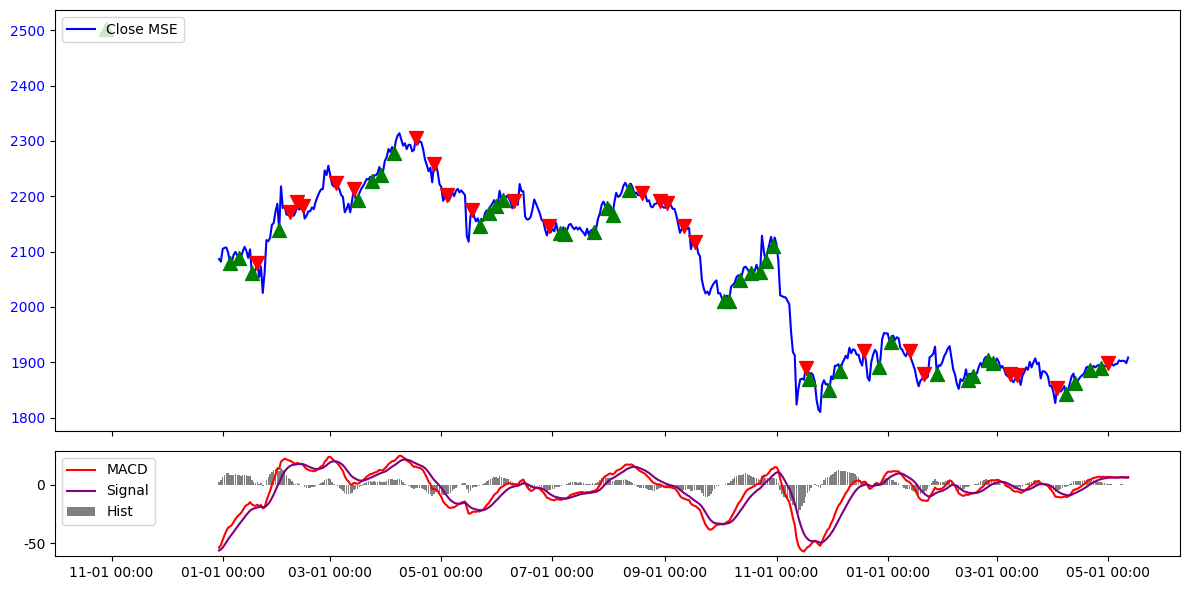

In [6]:
plot_stock(df, n=500)

/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_6176/2971110302.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['Hist'][-500:],df['Hist'][df['bottom_divergence']==1][-500:], marker='^', cmap='viridis')
/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_6176/2971110302.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['Hist'][-500:],df['Hist'][df['top_divergence']==1][-500:], marker='v', cmap='viridis')


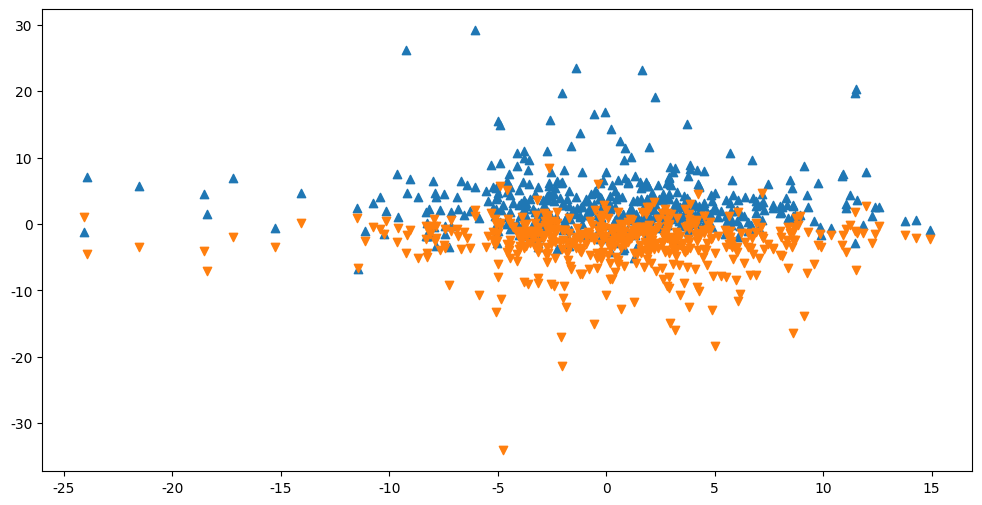

In [7]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Hist'][-500:],df['Hist'][df['bottom_divergence']==1][-500:], marker='^', cmap='viridis')
plt.scatter(df['Hist'][-500:],df['Hist'][df['top_divergence']==1][-500:], marker='v', cmap='viridis')

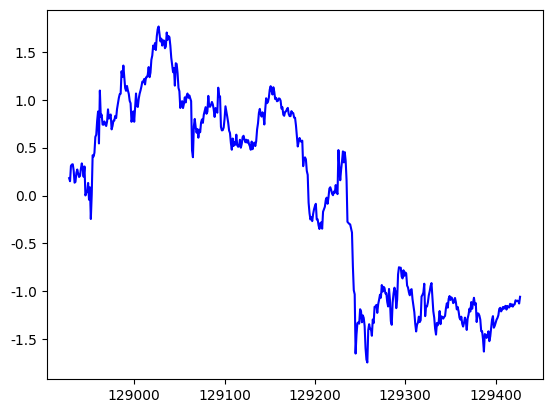

In [38]:
from sklearn.cluster import KMeans
n=500
tIndex = df.index[-n:]
train = df[-n:]

features = df[['close', 'MACD', 'macd_slope_ma3', 'hist_change_rate']][-n:]
features = (features - features.mean()) / features.std()
features
kmeans = KMeans(n_clusters=5, random_state=0)
features['cluster'] = kmeans.fit_predict(features)
# 识别聚类中心对应的峰谷
peak_center = features[features['cluster'] == 0].mean().idxmax()
valley_center = features[features['cluster'] == 1].mean().idxmin()
features['price_peak'] = (features['close'].rolling(20, center=True).max() == features['close']) &  (features['cluster'] == peak_center)
features['price_valley'] = (features['close'].rolling(20, center=True).min() == features['close']) &  (features['cluster'] == valley_center)

features[['close','cluster']]
# features[features['price_valley']].tail()

fig1 = plt.figure()
plt.plot(tIndex, features['close'], color='blue', label='Close MSE')
plt.scatter(features[features['price_peak']][-10:], features['close'][features['price_peak']][-10:], color='red', label='Peak')
plt.scatter(features[features['price_valley']][-10:], features['close'][features['price_valley']][-10:], color='green', label='Peak')
plt.show()